In [ ]:
# default_exp nbeats.learner

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats Learner

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.model import *
from fastseq.nbeats.callbacks import *

## Learner

In [ ]:
# export
# from fastai2.basics import *
# from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataLoaders, output_channels=None, metrics=None,cbs=None, b_loss=0., loss_func=None, opt_func=None, **kwargs):
    "Build a N-Beats style learner"
    model = NBeatsNet(
        device = dbunch.train.device,
        horizon = dbunch.train.horizon,
        lookback = dbunch.train.lookback,
        **kwargs
       )
    lb = dbunch.train.lookback
    loss_func = ifnone(loss_func, CombinedLoss(F.mse_loss, lb))
    cbs = L(cbs)
    if b_loss != 0.:
        raise NotImplementedError()
        cbs.append(NBeatsBLoss(b_loss))
    opt_func = ifnone(opt_func, ranger)
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= opt_func,
                    metrics=L(metrics)+L(mae, smape, NBeatsTheta(),
                                         NBeatsBackward(lb), NBeatsForward(lb), ForwardSMAPE(lb)
                                        ),
                    cbs=L(NBeatsAttention())+cbs
                   )
    learn.lh = (dbunch.train.lookback/dbunch.train.horizon)
    return learn

# Example

(1, 85)
Train:110; Valid: 20; Test 10


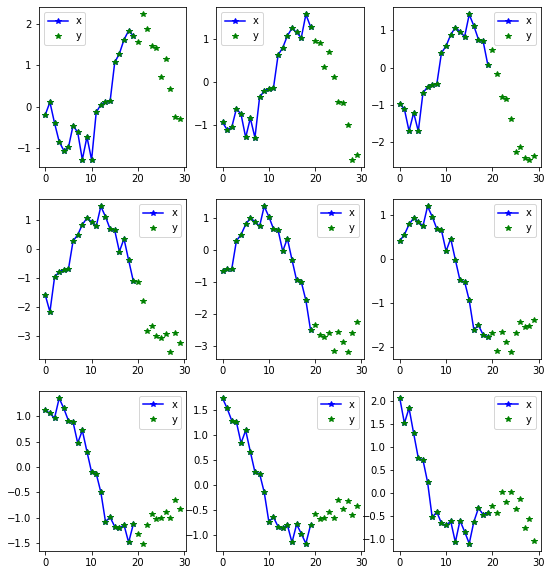

In [ ]:
horizon, lookback = 10,20
items = dummy_data_generator(75, 10, nrows=10)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=3, valid_pct=.5
                               )
data.show_batch()

In [ ]:
learn = nbeats_learner(data, metrics = NBeatsLossPart(0,-9,'Last'))

epoch,train_loss,valid_loss,Last,mae,smape,theta,b_loss,f_loss,f_smape,time
0,4.055482,6.740880,0.224454,1.293941,1.758495,0.081177,nan,nan,0.177269,00:00
1,3.561053,6.303481,0.204370,1.258995,1.641249,0.130358,nan,nan,0.162187,00:00
2,3.285988,5.812937,0.142687,1.211025,1.523428,0.284127,nan,nan,0.146093,00:00
3,3.162800,3.828631,0.138044,1.033271,1.137820,0.888826,nan,nan,0.090382,00:00
4,2.984971,3.706028,0.126525,1.008252,1.095180,1.042538,nan,nan,0.087805,00:00


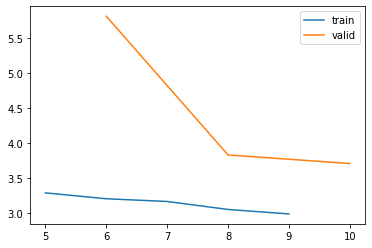

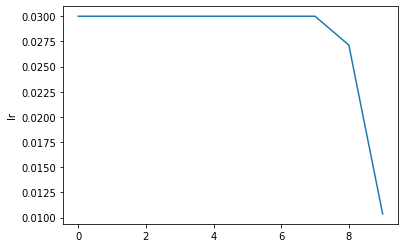

In [ ]:
learn.fit_flat_cos(5, 3e-2)
learn.recorder.plot_loss()
learn.recorder.plot_sched()

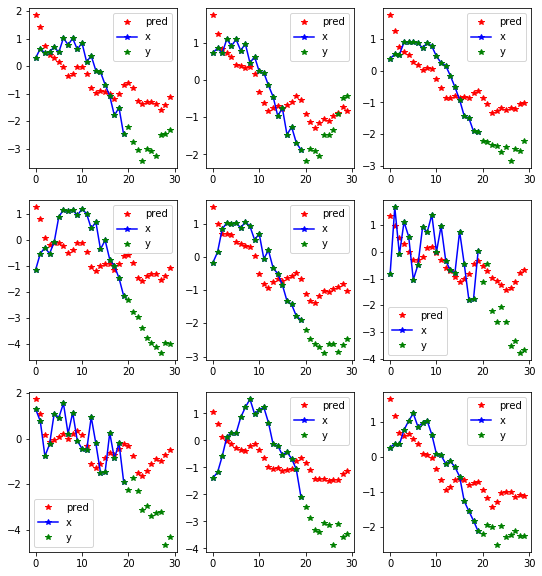

In [ ]:
learn.show_results()

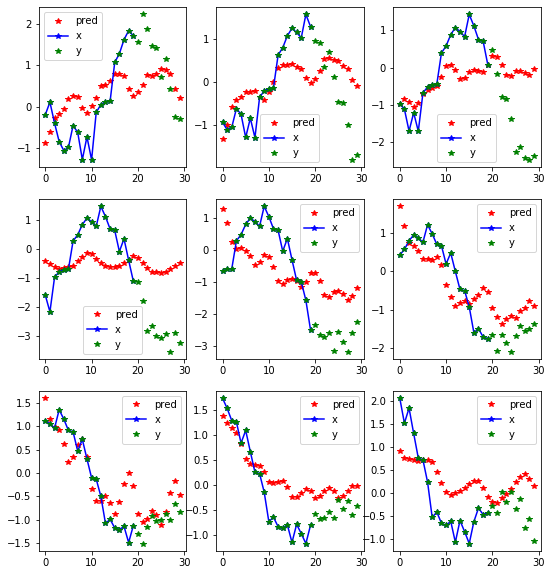

In [ ]:
learn.show_results(0)

In [ ]:
learn.n_beats_attention.means()

,trend0_0,trend0_1,seasonality1_0,seasonality1_1,seasonality1_2,seasonality1_3
theta_0_mean,-0.34815162,0.13803925,-0.042045634,-0.013083976,0.12572084,-0.029341366
theta_0_std,0.754271,0.58436155,0.33487004,0.40932173,0.3934554,0.275101
theta_1_mean,-0.011905082,0.0025204269,0.0057537355,0.0070921504,0.0035829465,0.0054545747
theta_1_std,0.02163868,0.016900145,0.047628935,0.07250203,0.048069395,0.04207551
theta_2_mean,-0.00095947157,0.0018632701,-0.08928383,-0.19620201,0.0005366651,0.008915225
theta_2_std,0.0020523414,0.002065569,0.33776814,0.8345761,0.008687078,0.020507267
theta_3_mean,-0.0013235792,-0.00010702384,NaN,0.002475145,0.028133215,0.15290838
theta_3_std,0.04677417,0.0002416877,NaN,0.023808345,0.3514603,0.6921449
theta_4_mean,0.2316803,-0.010887678,NaN,NaN,-0.0054325876,0.025822982
theta_4_std,0.312716,0.025095746,NaN,NaN,0.05490886,0.055042714


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.callbacks.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted 12_compare.ipynb.
Converted index.ipynb.
Converted normalize batch in model.ipynb.
